In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from qdax import environments
import jax

import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output


from utils.network import Sequential
import random

from IPython.display import HTML
from brax.v1.io import html

%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F
from torch.distributions import Categorical, Normal

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

In [3]:
from brax.io import torch as io_torch
import random

class TorchWrapper:
    def __init__(self, env, num_envs):
        
        self.env = env
        self.num_envs = num_envs
        self.state_dim = env.observation_size
        self.action_dim = env.action_size
        
        
        self.reset_fn = jax.jit(jax.vmap(env.reset))
        self.step_fn = jax.jit(jax.vmap(env.step))
        
        # self.reset_fn = jax.vmap(env.reset)
        # self.step_fn = jax.vmap(env.step)
        
    
    def reset(self, seed=None):
        
        random_key = jax.random.PRNGKey(random.randint(0, 99999999))
        keys = jax.random.split(random_key, num=self.num_envs)
        # random_key, subkey = jax.random.split(random_key)
        if seed == 1:
            keys = jax.random.PRNGKey(random.randint(0, 99999999))
        state = self.reset_fn(keys)
        self.state = state
        return io_torch.jax_to_torch(state.obs)
    
    def step(self, action: torch.Tensor):
        
        action = io_torch.torch_to_jax(action)
        next_state = self.step_fn(self.state, action)
        observation, reward, done, state_descriptor = next_state.obs, next_state.reward, next_state.done, next_state.info['state_descriptor']
        observation = io_torch.jax_to_torch(observation)
        reward = io_torch.jax_to_torch(reward)
        done = io_torch.jax_to_torch(done)
        # print('jax:', state_descriptor)
        state_descriptor = io_torch.jax_to_torch(state_descriptor)
        # print('torch:', state_descriptor)
        
        self.state = next_state
        
        return observation, reward, done, {'state_descriptor': state_descriptor}
        

In [4]:
# Hyperparameters
max_timesteps = 3000
n_epochs = 10
learning_rate = 0.0003
gamma = 0.99
eps_clip = 0.2
K_epochs = 4
action_std = 0.5
batch_size = 64
update_timestep = 2000

beta = 0.0

BEHAVIOR_DIM = 5

env_name = 'halfcheetah_uni'
reward_offset = environments.reward_offset[env_name]
reward_offset

9.231

In [5]:
def compute_gae(done, rewards, values, next_values, gamma=0.99, lambda_=0.95):
    assert len(values) == len(next_values) == len(rewards) == len(done)

    advantages = torch.zeros(done.shape[0], dtype=torch.float32)
    returns = torch.zeros(done.shape[0], dtype=torch.float32)
    last_advantage = 0
    last_return = 0

    for t in reversed(range(done.shape[0])):
        mask = 1.0 - done[t]
        last_value = next_values[t] * mask
        last_advantage = last_advantage * mask
        last_return = last_return * mask

        delta = rewards[t] + gamma * last_value - values[t]
        last_advantage = delta + gamma * lambda_ * last_advantage
        last_return = rewards[t] + gamma * last_return

        advantages[t] = last_advantage
        returns[t] = last_return

    return advantages, returns


def compute_gae_parallel(dones, rewards, values, next_values, gamma=0.99, lambda_=0.95):
    assert (
        dones.shape == rewards.shape == values.shape == next_values.shape
    ), "All inputs must have the same shape (num_envs, sequence_length)."

    num_envs, seq_len = dones.shape
    advantages = torch.zeros_like(rewards, dtype=torch.float32)
    returns = torch.zeros_like(rewards, dtype=torch.float32)
    last_advantage = torch.zeros(num_envs, dtype=torch.float32)
    last_return = torch.zeros(num_envs, dtype=torch.float32)

    for t in reversed(range(seq_len)):
        mask = 1.0 - dones[:, t]
        last_value = next_values[:, t] * mask
        last_advantage = last_advantage * mask
        last_return = last_return * mask

        delta = rewards[:, t] + gamma * last_value - values[:, t]
        last_advantage = delta + gamma * lambda_ * last_advantage
        last_return = rewards[:, t] + gamma * last_return

        advantages[:, t] = last_advantage
        returns[:, t] = last_return

    return advantages, returns

In [6]:
from brax.io import torch as io_torch
import random

class TorchGymWrapper:
    def __init__(self, env, num_envs):
        
        self.env = env
        self.num_envs = num_envs
        self.state_dim = env.observation_space.shape[-1]
        self.action_dim = env.action_space.shape[-1]
        
        
        pass
    
    def reset(self, seed=None):        
        state, _ = self.env.reset()
        return torch.tensor(state, dtype=torch.float32)
    
    def step(self, action: torch.Tensor):
        
        action = action.cpu().tolist()
        observation, reward, terminated, truncated, _ = self.env.step(action)
        done = (terminated | truncated)
        
        state_descriptor = [(int(5 in env_.data.contact.geom2), int(8 in env_.data.contact.geom2)) for env_ in self.env.envs]  
        
        observation = torch.tensor(observation, dtype=torch.float32)
        reward = torch.tensor(reward, dtype=torch.float32)
        done = torch.tensor(done, dtype=torch.float32)
        state_descriptor = torch.tensor(state_descriptor, dtype=torch.float32)
                
        return observation, reward, done, {'state_descriptor': state_descriptor}
        

In [7]:
class ConditionedActorCriticContinuous(nn.Module):
    def __init__(self, descriptor_dim, state_dim, action_dim, actor_hidden_layers, critic_hidden_layers, action_std):
        super(ConditionedActorCriticContinuous, self).__init__()
        
        # Define actor network
        actor_layers = []
        input_dim = state_dim
        for hidden_dim in actor_hidden_layers:
            actor_layers.append(nn.Linear(input_dim, hidden_dim))
            actor_layers.append(nn.ReLU())
            input_dim = hidden_dim
        actor_layers.append(nn.Linear(input_dim, action_dim))
        # actor_layers.append(nn.Tanh())
        self.actor = nn.Sequential(*actor_layers)
        
        # Define critic network
        critic_layers = []
        input_dim = state_dim
        for hidden_dim in critic_hidden_layers:
            critic_layers.append(nn.Linear(input_dim, hidden_dim))
            critic_layers.append(nn.ReLU())
            input_dim = hidden_dim
        critic_layers.append(nn.Linear(input_dim, 1))
        self.critic = nn.Sequential(*critic_layers)
        
        self.action_var = nn.Parameter(torch.full((action_dim,), action_std**2, requires_grad=True))


    def forward(self, x, action=None):
        # print(f"{alpha.shape=}")

        action_mean = self.actor(x)
        cov_matrix = torch.exp(self.action_var)
        dist = Normal(loc=action_mean, scale=cov_matrix)
        
        if action is None:
            action = dist.sample()
            
        log_p = dist.log_prob(action).sum(dim=-1)
        
        value = self.critic(x)
        
        return action, action_mean, log_p, value, dist.entropy()

In [8]:
def get_descriptor(info):
    d1 = np.mean([d1 for (d1, d2) in info])
    d2 = np.mean([d2 for (d1, d2) in info])
    return d1, d2
    # return np.mean(info['bfoot_touch_ground']), np.mean(info['ffoot_touch_ground'])
    
    
def get_descriptors_from_trajectories(data):
    
    num_envs = data['info'].shape[0]
    
    descriptors = []
    for n in range(num_envs):
        env_n_descriptors = []
        trajectory_info = []
        for i in range(len(data['info'][n])):
            # print(i)
            trajectory_info.append(data['info'][n][i])
            
            if data['done'][n][i] == True:
                d1, d2 = get_descriptor(trajectory_info)
                # d1, d2 = round(d1*BEHAVIOR_DIM), round(d2*BEHAVIOR_DIM)
                descriptors.append((d1, d2))
        
        # descriptors.append(env_n_descriptors)
        
    return descriptors




def descriptors_to_vectors(descriptors):
    vectors = []
    for (d1, d2) in descriptors:
        vector = [0]*(BEHAVIOR_DIM**2)
        vector[d1*BEHAVIOR_DIM+d2] = 1
        vectors.append(vector)
    return vectors

def descriptors_to_id(descriptors):
    ids = []
    for (d1, d2) in descriptors:
        ids.append(d1*BEHAVIOR_DIM+d2)
    return ids

def descriptors_vec2coord(descriptors):
    d_id = descriptors.argmax(axis=1)
    d1, d2 = d_id // BEHAVIOR_DIM, d_id % BEHAVIOR_DIM
    return torch.concat((d1.unsqueeze(0), d2.unsqueeze(0))).t().float() / BEHAVIOR_DIM

In [9]:
def random_descriptors(n):
    descriptors = torch.zeros((n, BEHAVIOR_DIM**2), dtype=torch.float32)
    for i in range(n):
        descriptors[i, torch.randint(0, BEHAVIOR_DIM**2, size=(1,))] = 1.
    return descriptors

In [10]:
def post_process(action):
    # return torch.tanh(action)
    return torch.clip(action, -1, 1)

In [11]:
def collect_trajectories(env: TorchWrapper, model, condition_descriptor, n_steps: int):

    states = torch.zeros((env.num_envs, n_steps, env.state_dim), dtype=torch.float32)
    actions = torch.zeros((env.num_envs, n_steps, env.action_dim), dtype=torch.float32)
    rewards = torch.zeros((env.num_envs, n_steps), dtype=torch.float32)
    log_ps = torch.zeros((env.num_envs, n_steps), dtype=torch.float32)
    state_values = torch.zeros((env.num_envs, n_steps), dtype=torch.float32)
    dones = torch.zeros((env.num_envs, n_steps), dtype=torch.float32)
    state_descriptors = torch.zeros((env.num_envs, n_steps, 2), dtype=torch.float32)

    
    advantages = np.zeros((env.num_envs, n_steps), dtype=np.float32)

    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]

    

    total_reward = 0
    step_count = 0

    for s in range(n_steps):
        # state = torch.FloatTensor(state).to(device)
        state = state.to(device)
        # print(state.shape, alpha.shape)
        with torch.no_grad():
            action, action_mean, log_p, state_value, entropy = model(state)
        next_state, reward, done, info_dict = env.step(post_process(action))
        
        states[:, s] = state.cpu()
        actions[:, s] = action.cpu()
        rewards[:, s] = reward.cpu()
        log_ps[:, s] = log_p.cpu().detach()
        state_values[:, s] = state_value.cpu().detach().reshape(-1)
        dones[:, s] = done.cpu()
        state_descriptors[:, s] = info_dict['state_descriptor'].cpu()
        # info[:, s] = [(int(5 in env_.data.contact.geom2), int(8 in env_.data.contact.geom2)) for env_ in env.envs]        

        state = next_state
        # total_reward += reward
        # step_count += 1

        # if done.any():
        #     # state, _ = env.reset(np.where(dones)[0])
        #     break
        #     state = env.reset()
    
    # print(state.shape, action.shape, rewards.shape, log_ps.shape, state_values.shape)
    
    achieved_descriptors = state_descriptors.mean(axis=-2)
    
        
    # Calculate the distance between the goal descriptor and the achieved descriptor:
    # descriptors_similarity = ((condition_descriptor - achieved_descriptors)**2).sum(axis=-1)
    # descriptors_similarity = torch.exp(-descriptors_similarity/0.1)
    descriptors_similarity = 1 - torch.abs(condition_descriptor - achieved_descriptors)
    descriptors_similarity = descriptors_similarity.prod(-1)
    
    
    # descriptors_similarity = achieved_descriptors.prod(-1)
    # descriptors_similarity = achieved_descriptors[:, 1]
    
    similarity_reward = descriptors_similarity.unsqueeze(1).repeat(1, n_steps).cpu()
    
    # similarity_reward = torch.zeros(env.num_envs, n_steps).cpu()
    # similarity_reward[:, -1] = descriptors_similarity
    
    
    # critic_x = torch.FloatTensor(next_state).to(device)
    critic_x = next_state.to(device)
    next_value = model.critic(critic_x).cpu()    
    
        
    # states = torch.tensor(states)
    # actions = torch.tensor(actions)
    real_rewards = rewards
    rewards = (real_rewards + reward_offset) * similarity_reward
    # rewards = real_rewards
    # rewards = (10+real_rewards) * similarity_reward
    
    # log_ps = torch.tensor(log_ps)
    # state_values = torch.tensor(state_values)
    # dones = torch.tensor(dones)
    next_state_values = torch.concatenate((state_values[:, 1:], next_value), dim=-1)
    

    # old_advantages, old_returns = [], []
    # for i in range(env.num_envs):
    #     a, r = compute_gae(dones[i], rewards[i], state_values[i], next_state_values[i])
    #     old_advantages.append(a)
    #     old_returns.append(r)
    # old_advantages = torch.stack(old_advantages)
    # old_returns = torch.stack(old_returns)
    
    # print(dones.shape, rewards.shape, state_values.shape, next_state_values.shape)
    advantages, returns = compute_gae_parallel(dones, rewards, state_values, next_state_values)
    
    # print(condition_descriptor)
    # print(achieved_descriptors)
    # print(descriptors_similarity)
    # print(rewards)
    # print(advantages)
    # print(returns)
    # return
    
    
    trajectories = {
        # "descriptors": condition_descriptor.unsqueeze(1).repeat(1, n_steps, 1).reshape(-1, BEHAVIOR_DIM**2),
        "states" :  states.reshape(-1, env.state_dim).detach(),
        "actions" : actions.reshape(-1, env.action_dim).detach(),
        "rewards" : rewards.reshape(-1).detach(),
        "dones" : dones.reshape(-1).detach(),
        "log_ps" : log_ps.reshape(-1).detach(),
        "state_values": state_values.reshape(-1).detach(),
        "next_state_values": next_state_values.reshape(-1).detach(),
        "returns" : returns.reshape(-1).detach(),
        "advantages" : advantages.reshape(-1).detach(),
        
    }

    return trajectories, {
        'state_descriptors':state_descriptors, 'done':dones, 
        'reward': rewards, 'real_reward': real_rewards, 
        'similarity': similarity_reward,
        'achieved_descriptors': achieved_descriptors.cpu().detach()
    }


def shufffle_trajectory(trajectories):
    length = trajectories['states'].shape[0]
    permutation = torch.randperm(length)

    shuffled_trajectories = {key: tensor[permutation] for key, tensor in trajectories.items()}
    return shuffled_trajectories

In [12]:
# condition_descriptors = torch.tensor([(1., 1.)]).repeat(env.num_envs, 1)
# trajectory, info = collect_trajectories(env, model, condition_descriptors, n_steps=max_episode_steps)

In [13]:
def ppo_optimization(trajectories, model, optimizer, epochs, batch_size):
    
    model.train()
    
    traj_states = trajectories["states"]
    traj_actions = trajectories["actions"]
    traj_log_ps = trajectories["log_ps"]
    traj_returns = trajectories["returns"]  
    traj_advantages = trajectories["advantages"]


    len_trajectory = traj_states.shape[0]

    for epoch in range(1, epochs+1):
        for i in range(len_trajectory // batch_size):
            state = traj_states[batch_size*i:batch_size*(i+1)].to(device)
            action = traj_actions[batch_size*i:batch_size*(i+1)].to(device)
            log_p = traj_log_ps[batch_size*i:batch_size*(i+1)].to(device)
            return_ = traj_returns[batch_size*i:batch_size*(i+1)].to(device)
            advantage = traj_advantages[batch_size*i:batch_size*(i+1)].to(device)
                        
            # print(alpha)
            new_action, new_action_mean, new_log_p, new_state_value, entropy = model(state, action)
            assert(new_action == action).all()
            
            
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

            new_log_p, log_p, advantage = new_log_p.reshape(-1), log_p.reshape(-1), advantage.reshape(-1)
            
            ratio = torch.exp(new_log_p - log_p.detach())
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-0.2, 1+0.2) * advantage
            policy_loss = - torch.min(surr1, surr2).mean()
            
            # print(ratio.shape, advantage.shape, surr1.shape, surr2.shape, torch.min(surr1, surr2).shape)
            
            return_, new_state_value = return_.reshape(-1), new_state_value.reshape(-1)
            critic_loss = ((return_ - new_state_value)**2).mean()
        

            loss = policy_loss - 2e-7*entropy.mean() + 0.5*critic_loss

            optimizer.zero_grad()
            loss.backward()
            clip_factor = torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

# ppo_optimization(trajectories, model, optimizer, epochs=1, batch_size=5)
# ppo_optimization(shuffled_trajectory, model, alpha, optimizer, epochs=5, batch_size=256)

In [14]:
def evaluate(env, model, descriptor):
    model.eval()

    state, _ = env.reset()
        
    total_reward = 0
    step_count = 0

    trajectory = []
    info = []
    

    while True:
        trajectory.append(state)
        state = state.to(device).unsqueeze(0)
        with torch.no_grad():
            action, mean_action, log_p, state_value, entropy = model(state)
        next_state, reward, terminated, truncated, _ = env.step(post_process(action)[0].cpu().tolist())

        info.append((
            int(5 in env.data.contact.geom2), int(8 in env.data.contact.geom2)
        ))
        
        done = terminated or truncated

        state = next_state
        total_reward += reward
        step_count += 1
        
        
        if done:
            break
        
    return total_reward, trajectory, info


def get_reward_from_trajectory(info):
    reward_list = []
    real_reward_list = []
    sim_list = []
    acc_reward = 0
    acc_real_reward = 0
    acc_similarity = 0
    cnt = 0
    for n in range(len(info['reward'])):
        for i in range(len(info['reward'][n])):
            if info['done'][n][i] == True:
                reward_list.append(acc_reward)
                real_reward_list.append(acc_real_reward)
                sim_list.append(info['similarity'][n][-1])
                acc_reward = 0
                acc_real_reward = 0
                acc_similarity = 0
                cnt = 0
            
            acc_reward += info['reward'][n][i]
            acc_real_reward += info['real_reward'][n][i]
            acc_similarity += info['similarity'][n][i]
            cnt += 1

    return np.mean(reward_list), np.mean(real_reward_list), np.mean(sim_list)

In [15]:
from qdax.environments import FeetContactWrapper
import brax
# from brax.envs.wrappers import training
from brax.v1.envs import wrappers

In [16]:
max_episode_steps = 100

num_envs = 128

# from brax import envs

# ENV_NAME = "halfcheetah"
# brax_env = wrappers.AutoResetWrapper(
#     wrappers.EpisodeWrapper(
#         brax.v1.envs.half_cheetah.Halfcheetah(), 
#         max_episode_steps, 
#         1
#     )
# )
# base_env = FeetContactWrapper(brax_env, ENV_NAME)

base_env = environments.create(env_name="halfcheetah_uni", episode_length=max_episode_steps)
env = TorchWrapper(base_env, num_envs=num_envs)

observation = env.reset()

state_dim = env.env.observation_size
action_dim = env.env.action_size

In [20]:
# # env = gym.vector.make('HalfCheetah-v4', render_mode = "rgb_array", num_envs=8)

# max_episode_steps = 1000
# num_envs = 8
# env_fns = [lambda: gym.make('HalfCheetah-v4', render_mode="rgb_array", max_episode_steps=max_episode_steps) for _ in range(num_envs)]
# base_env = gym.vector.SyncVectorEnv(env_fns)
# env = TorchGymWrapper(base_env, num_envs=num_envs)

# state_dim = env.state_dim
# action_dim = env.action_dim

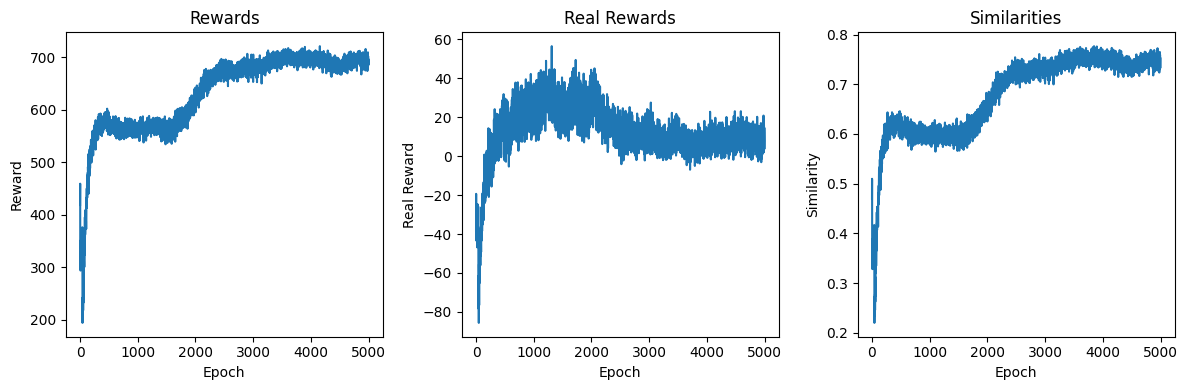

Reward: 694.99: 100%|██████████| 5000/5000 [1:11:36<00:00,  1.16it/s]


In [74]:
model = ConditionedActorCriticContinuous(
    BEHAVIOR_DIM**2,
    state_dim,
    action_dim,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256],
    action_std=0.5
).to(device)
# model.load_state_dict(torch.load('models/d=(0, 0)+run.pt'))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003)


rewards, real_rewards, similarities = [], [], []
all_descriptors = []
all_condition_descriptors = []

H_d_a_list = []
H_d_list = []
cross_entropies = []
diversity_lossses = []

tqdm_epochs = tqdm(range(1, 5000+1))
for epochs in tqdm_epochs:
    
    
    for _ in range(1):
        # condition_descriptors = random_descriptors(env.num_envs).to(device)
        # condition_descriptors = torch.tensor(descriptors_to_vectors([(4,4)]), dtype=torch.float32).repeat(env.num_envs, 1).to(device)
        condition_descriptors = torch.tensor([(0., 0.)]).repeat(env.num_envs, 1)
        trajectory, info = collect_trajectories(env, model, condition_descriptors, n_steps=max_episode_steps)
        descriptors = np.round(info['achieved_descriptors'].tolist(), 2).tolist()
        
        all_condition_descriptors += condition_descriptors.tolist()
        all_descriptors += descriptors
        print(descriptors)

    shuffled_trajectory = shufffle_trajectory(trajectory)
    diversity_loss = ppo_optimization(shuffled_trajectory, model, optimizer, epochs=4, batch_size=512)
    diversity_lossses.append(diversity_loss)
    
    final_reward, final_real_reward, final_similarity = get_reward_from_trajectory(info)
    rewards.append(max(final_reward, -3000))
    real_rewards.append(max(final_real_reward, -3000))
    similarities.append(final_similarity)
    
    tqdm_epochs.set_description(f'Reward: {final_reward:.2f}')
    
    
    if epochs % 10 == 0:
        clear_output(True)
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].plot(rewards)
        axes[0].set_title('Rewards')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Reward')
        
        axes[1].plot(real_rewards)
        axes[1].set_title('Real Rewards')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Real Reward')
        
        axes[2].plot(similarities)
        axes[2].set_title('Similarities')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Similarity')

        # Display the plots
        plt.tight_layout()
        plt.show()

In [75]:
torch.save(model.state_dict(), 'models/d=(0, 0)+run.pt')  

---

In [18]:
# model = ConditionedActorCriticContinuous(
#     BEHAVIOR_DIM**2,
#     state_dim,
#     action_dim,
#     actor_hidden_layers=[256, 256],
#     critic_hidden_layers=[256, 256],
#     action_std=0.5
# ).to(device)

# model.load_state_dict(torch.load('models/max_d.pt'))

/tmp/ipykernel_7480/1009690023.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/max_d.pt'))


<All keys matched successfully>

In [66]:
eval_base_env = environments.create('halfcheetah_uni', episode_length=max_episode_steps)
eval_env = TorchWrapper(eval_base_env, num_envs=1)

state_dim = env.env.observation_size
action_dim = env.env.action_size

In [67]:
state = eval_env.reset()

total_reward = 0
step_count = 0

rollout = []

eval_state_descriptor = []

for s in tqdm(range(max_episode_steps)):
    state = state.to(device)
    with torch.no_grad():
        action, action_mean, log_p, state_value, entropy = model(state)
    next_state, reward, done, info_dict = eval_env.step(post_process(action))

    state = next_state    
    
    rollout.append(
        brax.v1.envs.env.State(
            qp=brax.v1.physics.base.QP(
                pos=eval_env.state.qp.pos.reshape(8, 3),
                rot=eval_env.state.qp.rot.reshape(8, 4),
                vel=eval_env.state.qp.vel,
                ang=eval_env.state.qp.ang,
            ),
            obs=eval_env.state.obs,
            reward=eval_env.state.reward,
            done=eval_env.state.done,
            info=eval_env.state.info,
        )
    )
    
    eval_state_descriptor.append(info_dict['state_descriptor'].cpu())
# eval_state_descriptor  = torch.concat(eval_state_descriptor, dim=0).mean(dim=1).tolist()
torch.concat(eval_state_descriptor, dim=0).mean(0)

100%|██████████| 100/100 [00:03<00:00, 26.60it/s]


tensor([0.3600, 0.4000])

In [68]:
HTML(html.render(eval_env.env.sys, [s.qp for s in rollout]))    

---

In [62]:
def plot_map_elite(eval_reward, eval_state_descriptor):

    x1, x2 = 0, 1

    x1_min = 0
    x1_max = 1
    x2_min = 0
    x2_max = 1

    N = 30

    x1_bins = np.linspace(x1_min, x1_max, N)
    x2_bins = np.linspace(x2_min, x2_max, N)

    map_grid = np.full((N, N), np.nan)


    def get_bin(value, bins):
        return np.digitize(value, bins) - 1


    for reward, descriptor in zip(eval_reward, eval_state_descriptor):
        feature1, feature2 = descriptor[x1], descriptor[x2]
        f1_bin = get_bin(feature1, x1_bins)
        f2_bin = get_bin(feature2, x2_bins)
        
        # reward = 1
        if np.isnan(map_grid[f1_bin, f2_bin]):
            map_grid[f1_bin][f2_bin] = reward
            # map_grid[f1_bin][f2_bin] = 0
        else:
            map_grid[f1_bin][f2_bin] = max(map_grid[f1_bin][f2_bin], reward)
            # map_grid[f1_bin][f2_bin] += 1


    fig, axs = plt.subplots(1, 1, figsize=(5,5))


    # cax = axs.matshow(map_grid, cmap="viridis", vmin=0, vmax=1)
    cax = axs.matshow(map_grid, cmap="viridis",)
    axs.set_title('DDPG\n(Full oobservation)', loc='center')

    axs.set_xlabel('bfoot touch ground')
    axs.set_ylabel('ffoot touch ground')
    axs.set_xticks(np.linspace(0, N-1, num=11))
    axs.set_xticklabels(np.round(np.linspace(0, 1, num=11), 2))
    axs.set_yticks(np.linspace(0, N-1, num=11))
    axs.set_yticklabels(np.round(np.linspace(0, 1, num=11), 2))
        
    fig.colorbar(cax, ax=axs, orientation='vertical', label='Reward')
    plt.show()

In [47]:
# model = ConditionedActorCriticContinuous(
#     BEHAVIOR_DIM**2,
#     state_dim,
#     action_dim,
#     actor_hidden_layers=[256, 256],
#     critic_hidden_layers=[256, 256],
#     action_std=0.5
# ).to(device)

# model.load_state_dict(torch.load('models/d=(0, 0)+run.pt'))

In [69]:
eval_base_env = environments.create('halfcheetah_uni', episode_length=max_episode_steps)
eval_env = TorchWrapper(eval_base_env, num_envs=2000)

In [70]:
state = eval_env.reset()

eval_state_descriptor = []
eval_reward = []

for s in tqdm(range(max_episode_steps)):
    # state = torch.FloatTensor(state).to(device)
    state = state.to(device)
    # print(state.shape, alpha.shape)
    with torch.no_grad():
        action, action_mean, log_p, state_value, entropy = model(state)
    next_state, reward, done, info_dict = eval_env.step(post_process(action_mean))
    eval_state_descriptor.append(info_dict['state_descriptor'].cpu().unsqueeze(0))
    eval_reward.append(reward)
    
    state = next_state
# eval_state_descriptor  = torch.concat(eval_state_descriptor, dim=0).mean(dim=1).tolist()

eval_state_descriptor = torch.concat(eval_state_descriptor, dim=0).mean(0)
eval_reward = torch.stack(eval_reward).sum(dim=1)

eval_state_descriptor

100%|██████████| 100/100 [00:04<00:00, 21.88it/s]


tensor([[0.2500, 0.4500],
        [0.4300, 0.3700],
        [0.5100, 0.5100],
        ...,
        [0.4500, 0.4300],
        [0.5000, 0.4200],
        [0.4400, 0.3700]])

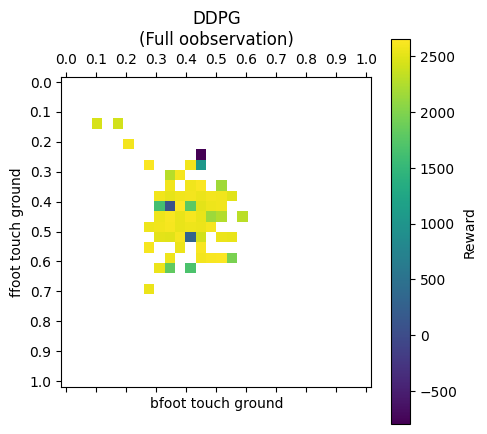

In [71]:
plot_map_elite(eval_reward, eval_state_descriptor)

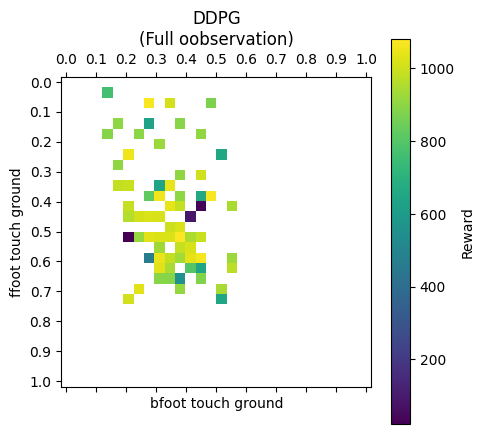

In [51]:
plot_map_elite(eval_reward, eval_state_descriptor)

In [ ]:
model = ActorCriticContinuous(
    1,
    state_dim,
    action_dim,
    same_init=False,
    actor_hidden_layers=[256, 256],
    critic_hidden_layers=[256, 256],
    action_std=0.5
).to(device)

model.load_state_dict(torch.load('models/halfcheetah/n_anchors=1.pt'))


NameError: name 'ActorCriticContinuous' is not defined

In [ ]:
import gym

In [ ]:
one_env = gym.make('HalfCheetah-v4', render_mode="rgb_array", max_episode_steps=100)

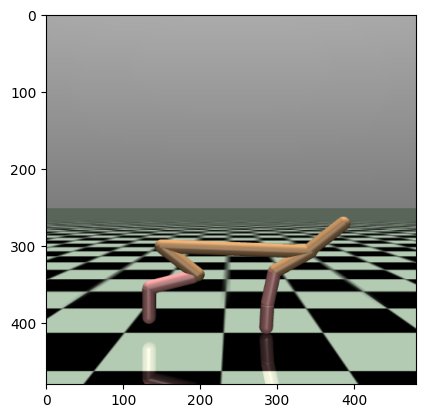

  3%|▎         | 99/3000 [00:08<04:02, 11.95it/s]

False True
-2945.8035999225435


In [ ]:
from time import sleep

alpha = torch.tensor([0.5.]).to(device)

state, _ = one_env.reset()
total_reward = 0
tqdm_range = tqdm(range(max_timesteps))
for t in tqdm_range:
    state = torch.FloatTensor(state).to(device)
    with torch.no_grad():
        action, log_p, state_value, entropy = model(state, alpha)
    # action = torch.normal(0, 1, size=(action.shape))
    next_state, reward, terminated, truncated, _ = one_env.step(action[0].cpu().tolist())
    done = terminated or truncated
    
    # Add data to memory
    # memory.add(state, action, reward, action_logprob, done)
    state = next_state
    total_reward += reward
    
    clear_output(True)
    frame = one_env.render()
    plt.imshow(frame)
    plt.show()
    
    # print(env.get_body_com('ffoot'))
    # print(env.data.body('bfoot').cfrc_int, env.data.body('ffoot').cfrc_int)
    
    
    # print(env.data.body('ffoot').xipos)
    # print(env.data.body('bfoot').cfrc_ext.any(), env.data.body('ffoot').cfrc_ext.any())
    # print(env.data.contact)
    print(5 in one_env.data.contact.geom2, 8 in one_env.data.contact.geom2)
    
    # if env.data.contact.H.shape[0] != 0:
        # break
    
    if done:
        break
    
    # sleep(1)
    
print(total_reward)

In [ ]:
env.data.contact.geom2

array([5, 8], dtype=int32)

In [ ]:
env.data.body

<bound method PyCapsule.body of <mujoco._structs.MjData object at 0x754a173cd070>>

In [ ]:
env.data.body('ffoot').cfrc_int

array([  0.        ,  22.1293691 ,   0.        , -52.90674133,
         0.        , -13.8416032 ])

In [ ]:
env.data.body('bfoot').cfrc_int

array([  0.        , -65.58391056,   0.        , 124.25011867,
         0.        , -41.76418074])

In [ ]:
env.data.body('bfoot')

<_MjDataBodyViews
  cacc: array([   0.        , -731.05017666,    0.        ,  -51.67292521,
          0.        ,  575.00922327])
  cfrc_ext: array([0., 0., 0., 0., 0., 0.])
  cfrc_int: array([  0.        , -65.58391056,   0.        , 124.25011867,
         0.        , -41.76418074])
  cinert: array([ 0.05770359,  0.76445357,  0.70785189,  0.        , -0.19661607,
        0.        , -0.87857201,  0.        , -0.24193659,  1.09539749])
  crb: array([ 0.05770359,  0.76445357,  0.70785189,  0.        , -0.19661607,
        0.        , -0.87857201,  0.        , -0.24193659,  1.09539749])
  cvel: array([ 0.        ,  7.11009233,  0.        ,  5.33851089,  0.        ,
       -5.19108022])
  id: 4
  name: 'bfoot'
  subtree_angmom: array([0., 0., 0.])
  subtree_com: array([2.04672575, 0.        , 0.42603072])
  subtree_linvel: array([0., 0., 0.])
  xfrc_applied: array([0., 0., 0., 0., 0., 0.])
  ximat: array([ 0.77652312,  0.        ,  0.63008876,  0.        ,  1.        ,
        0.        

In [ ]:
from datetime import datetime
now = datetime.now()
formatted_time = now.strftime("%d/%m/%Y-%H:%M:%S")
formatted_time

'03/11/2024-21:15:50'

In [ ]:
datetime.now

AttributeError: module 'datetime' has no attribute 'now'